In [1]:
import os

import multiprocessing
import pydash as _

from cfg import conabio_ml

In [2]:
from conabio_ml.datasets.collections import Collection
from conabio_ml.pipeline import Pipeline
from conabio_ml.datasets.text.dataset import Dataset, Partitions

from conabio_ml.preprocessing.text.preprocessing import PreProcessing
from conabio_ml.preprocessing.text.transform import Transform

from conabio_ml.trainer.trainer_config import TrainerConfig

from conabio_ml.trainer.unsupervised import Vectorizers

from conabio_ml.trainer.unsupervised.trainer import UnsupervisedTrainer
from conabio_ml.trainer.keras_bcknd import KerasTrainer, KerasTrainerConfig, KerasModel
from conabio_ml.trainer.keras_bcknd import TENSORBOARD_CALLBACK

from pdb import set_trace as bp

Using TensorFlow backend.


In [3]:
from models import LSTM_MATRIX

In [4]:
from conabio_ml.utils.logger import get_logger
logger = get_logger(__name__)

In [5]:
dataset_url = "http://www.conabio.gob.mx/ibunam_files/conabio_ml_collections/text/20_newsgroups.tar.gz"
dataset_path = os.path.join(".", "datasets", "newsgroup")
results_path = os.path.join('./results', 'newsgroup')

In [6]:
def reader(row):
    lines = ""

    with open(row, encoding="ISO-8859-1") as _file:
        try:
            lines = _file.read()
        except Exception as ex:
            logger.exception(ex)

    try:
        temp = _.chain(enumerate(lines.splitlines()))\
            .filter(lambda x: x[1].endswith("writes:"))\
                .value()

        temp_lines = _.chain(lines.splitlines())\
            .filter(lambda x: x.startswith("Lines"))\
            .value()

        if len(temp) >= 1:
            line = temp[0][0]
            lines = "\n".join(lines.splitlines()[line+1:])
        elif len(temp_lines) >= 1:
            line_qty = temp_lines[0].split(":")[1]
            line_qty = int(line_qty)
            lines = "\n".join(lines.splitlines()[-int(line_qty)-1:])
        else:
            logger.warning(f"Line quantity of the file {row} is not set. "
                           f"All file will be used")
            lines = "\n".join(_.chain(lines.splitlines())
                              .filter(lambda x: len(x) > 0)
                              .value())
    except ValueError:
        logger.warning(f"Line quantity of the file {row} is not a number. "
                       f"All file will be used")

        lines = "\n".join(_.chain(lines.splitlines())
                           .filter(lambda x: len(x) > 0)
                           .value())
    except Exception as ex:
        logger.exception(ex)
        raise

    return lines

In [7]:
pipeline = Pipeline(results_path)\
    .add_process(name="newsgroup_from_folder",
                 action=Dataset.from_folder,
                 args={
                     "source_path": dataset_path,
                     "extensions": [""],
                     "recursive": True,
                     "split_by_folder": False,
                     "item_reader": reader,
                     "ratio": 0.1,
                     "lang": "en"
                 })\
    .add_process(name="filter_newsgroup",
                 action=Dataset.filter_dataset,
                 inputs_from_processes=["newsgroup_from_folder"],
                 args={
                     "column": "label",                 
                     "filter_expression": ["sci.space", "rec.actos"] 
                 })\
    .add_process(name="split_newsgroup",
                 action=Dataset.split,
                 inputs_from_processes=["filter_newsgroup"],
                 args={
                     "train_perc": 0.7,
                     "test_perc": 0.2,
                     "val_perc": 0.1
                 })\
    .add_process(name="normalize_newsgroup",
                 action=PreProcessing.normalize,
                 inputs_from_processes=["split_newsgroup"],
                 args={
                     "partitions": [],  # Applied to all partitions
                     "normalize_args": {
                         "delimit": True
                     }
                 })\
    .add_process(name="remove_stop_words_newsgroup",
                 action=PreProcessing.remove_stop_words,
                 inputs_from_processes=["normalize_newsgroup"],
                 args={
                     "partitions": [],  # Applied to all partitions
                 })\
    .add_asset(name="to_csv_newsgroup",
               action=Dataset.to_csv,
               inputs_from_processes=["remove_stop_words_newsgroup"])\
    .add_process(name="create_word2vec",
                 action=Vectorizers.Word2Vec.create,
                 args={
                     "min_count": 1,
                     "workers": multiprocessing.cpu_count() - 1,
                     "window": 4,
                     "size": 100
                 })\
    .add_process(name="as_ngram_array_newsgroup",
                 action=Transform.as_ngram_array,
                 inputs_from_processes=["to_csv_newsgroup"],
                 args={
                     "opts": {
                         "ngram_size": 1
                     }
                 })\
    .add_process(name="train_word2vec_newsgroup",
                 action=UnsupervisedTrainer.train,
                 inputs_from_processes=["as_ngram_array_newsgroup",
                                        "create_word2vec"],
                 args={
                     "execution_config": None,
                     "train_config": {
                         "epochs": 2
                     }
                 })\
    .add_process(name="as_one_hot_newsgroup",
                 action=Transform.as_one_hot,
                 inputs_from_processes=["to_csv_newsgroup"],
                 args={
                     "opts": {
                         "padding_sequences": 100,
                         "word_dictionary": None,
                         "vocab_size": None
                     }
                 })\
    .add_process(name="word2vec_matrix",
                 action=Vectorizers.Word2Vec.get_resource,
                 inputs_from_processes=["train_word2vec_newsgroup"],
                 args={
                     "resource": "word_matrix"
                 })\
    .add_process(name="create_keras_trainer_cfg",
                 action=KerasTrainerConfig.create,
                 args={
                     'checkpoint_dir': os.path.join(results_path, "checkpoints"),
                     'log_dir': os.path.join(results_path, "log_dir")
                 })\
    .add_process(name="create_lstm",
                 action=LSTM_MATRIX.create,
                 inputs_from_processes=["word2vec_matrix"],
                 args={
                     "model_config": {
                         "LSTM": {
                             "layers": {
                                 'embedding_layer': {
                                     'input_dim': 100,
                                     'output_dim': 100,
                                     'window': 10,
                                     'initializer': 'uniform'
                                 },
                                 'lstm_layer': {
                                     'output_dim': 128
                                 },
                                 'dense_layer': {
                                     'output_dim': 2
                                 },
                                 'activation': {
                                     'activation': 'softmax'
                                 }
                             }
                         }
                     }
                 })\
    .add_process(name="train_LSTM_newsgroup",
                 action=KerasTrainer.train,
                 inputs_from_processes=['as_one_hot_newsgroup',
                                        'create_lstm',
                                        'create_keras_trainer_cfg'],
                 args={
                     'train_config': {
                         'LSTM': {
                             'optimizer': {
                                 'adam': {
                                     'learning_rate': {
                                         'constant': {
                                             'learning_rate': 0.001,
                                         }
                                     }
                                 }
                             },
                             'loss': {
                                 'categorical_crossentropy': {}
                             },
                             'epochs': 3,
                             'batch_size': 64,
                             'shuffle': True,
                             'metrics': ['accuracy'],
                             'callbacks': {
                                 TENSORBOARD_CALLBACK: {
                                     # CHECK: TENSORBOARD CALLBACK VALUES ARE BOUNDED TO KERAS 2.0.3 CHECK  http://faroit.com/keras-docs/2.0.3/callbacks/
                                     'log_dir': os.path.join(results_path, "log")
                                 }
                             },
                             "labels_as_categorical": True
                         }
                     }
                 })\
    .add_process(name="predict_newsgroup",
                 action=KerasModel.predict,
                 inputs_from_processes=['train_LSTM_newsgroup',
                                        'as_one_hot_newsgroup'],
                 args={
                     "partition": Partitions.TEST
                 })

In [9]:
pipeline.run()

2019-11-14 14:18:10,047 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from folder: /Users/rrivera/Documents/mina.de.carbon/projects/conabio_ml/examples/notebooks/text/datasets/newsgroup
2019-11-14 14:18:10,372 [conabio_ml.datasets.dataset] [DEBUG]  19998 found files for extensions ./datasets/newsgroup/
2019-11-14 14:18:10,985 [__main__    ] [WARNI]  Line quantity of the file ./datasets/newsgroup/rec.autos/103220 is not set. All file will be used
2019-11-14 14:18:11,233 [__main__    ] [WARNI]  Line quantity of the file ./datasets/newsgroup/rec.autos/103411 is not set. All file will be used
2019-11-14 14:18:11,480 [__main__    ] [WARNI]  Line quantity of the file ./datasets/newsgroup/comp.sys.mac.hardware/52152 is not set. All file will be used
2019-11-14 14:18:11,493 [__main__    ] [WARNI]  Line quantity of the file ./datasets/newsgroup/comp.sys.mac.hardware/50423 is not set. All file will be used
2019-11-14 14:18:11,577 [__main__    ] [WARNI]  Line quantity of the file ./data

2019-11-14 14:19:39,562 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 51 and the sequence is 100 in partition train
2019-11-14 14:19:39,564 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 40 and the sequence is 100 in partition train
2019-11-14 14:19:39,568 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 23 and the sequence is 100 in partition train
2019-11-14 14:19:39,571 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 57 and the sequence is 100 in partition train
2019-11-14 14:19:39,574 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 42 and the sequence is 100 in partition train
2019-11-14 14:19:39,577 [conabio_ml.prep

2019-11-14 14:19:39,675 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 331 and the sequence is 100 in partition train
2019-11-14 14:19:39,678 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 78 and the sequence is 100 in partition train
2019-11-14 14:19:39,680 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 21 and the sequence is 100 in partition train
2019-11-14 14:19:39,683 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 103 and the sequence is 100 in partition train
2019-11-14 14:19:39,686 [conabio_ml.preprocessing.text.transform] [WARNI]  Not all the item can be converted to sequence, the size of the item is 85 and the sequence is 100 in partition train
2019-11-14 14:19:39,688 [conabio_ml.pr

2019-11-14 14:19:39,873 [conabio_ml.datasets.dataset] [DEBUG]  Categories of dataset: ['sci.space']
2019-11-14 14:19:39,874 [conabio_ml.datasets.dataset] [DEBUG]  Columns for data: ['index', 'item', 'label', 'partition']
2019-11-14 14:19:40,801 [conabio_ml.trainer.keras_bcknd] [DEBUG]  MODEL SUMMARY
2019-11-14 14:19:40,803 [conabio_ml.trainer.keras_bcknd] [DEBUG]  None
2019-11-14 14:19:40,885 [conabio_ml.trainer.keras_bcknd] [ERROR]  Error when checking target: expected activation_2 to have shape (2,) but got array with shape (1,)
Traceback (most recent call last):
  File "../../../conabio_ml/trainer/keras_bcknd.py", line 602, in train
    execution_config=execution_config)
  File "../../../conabio_ml/trainer/keras_bcknd.py", line 438, in fit
    callbacks=model_callbacks)
  File "/Users/rrivera/Documents/mina.de.carbon/projects/conabio_ml/lib/python3.7/site-packages/keras/engine/training.py", line 952, in fit
    batch_size=batch_size)
  File "/Users/rrivera/Documents/mina.de.carbon/p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          562800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 680,306
Trainable params: 117,506
Non-trainable params: 562,800
_________________________________________________________________


2019-11-14 14:19:41,029 [conabio_ml.trainer.keras_bcknd] [WARNI]  Not implemented method


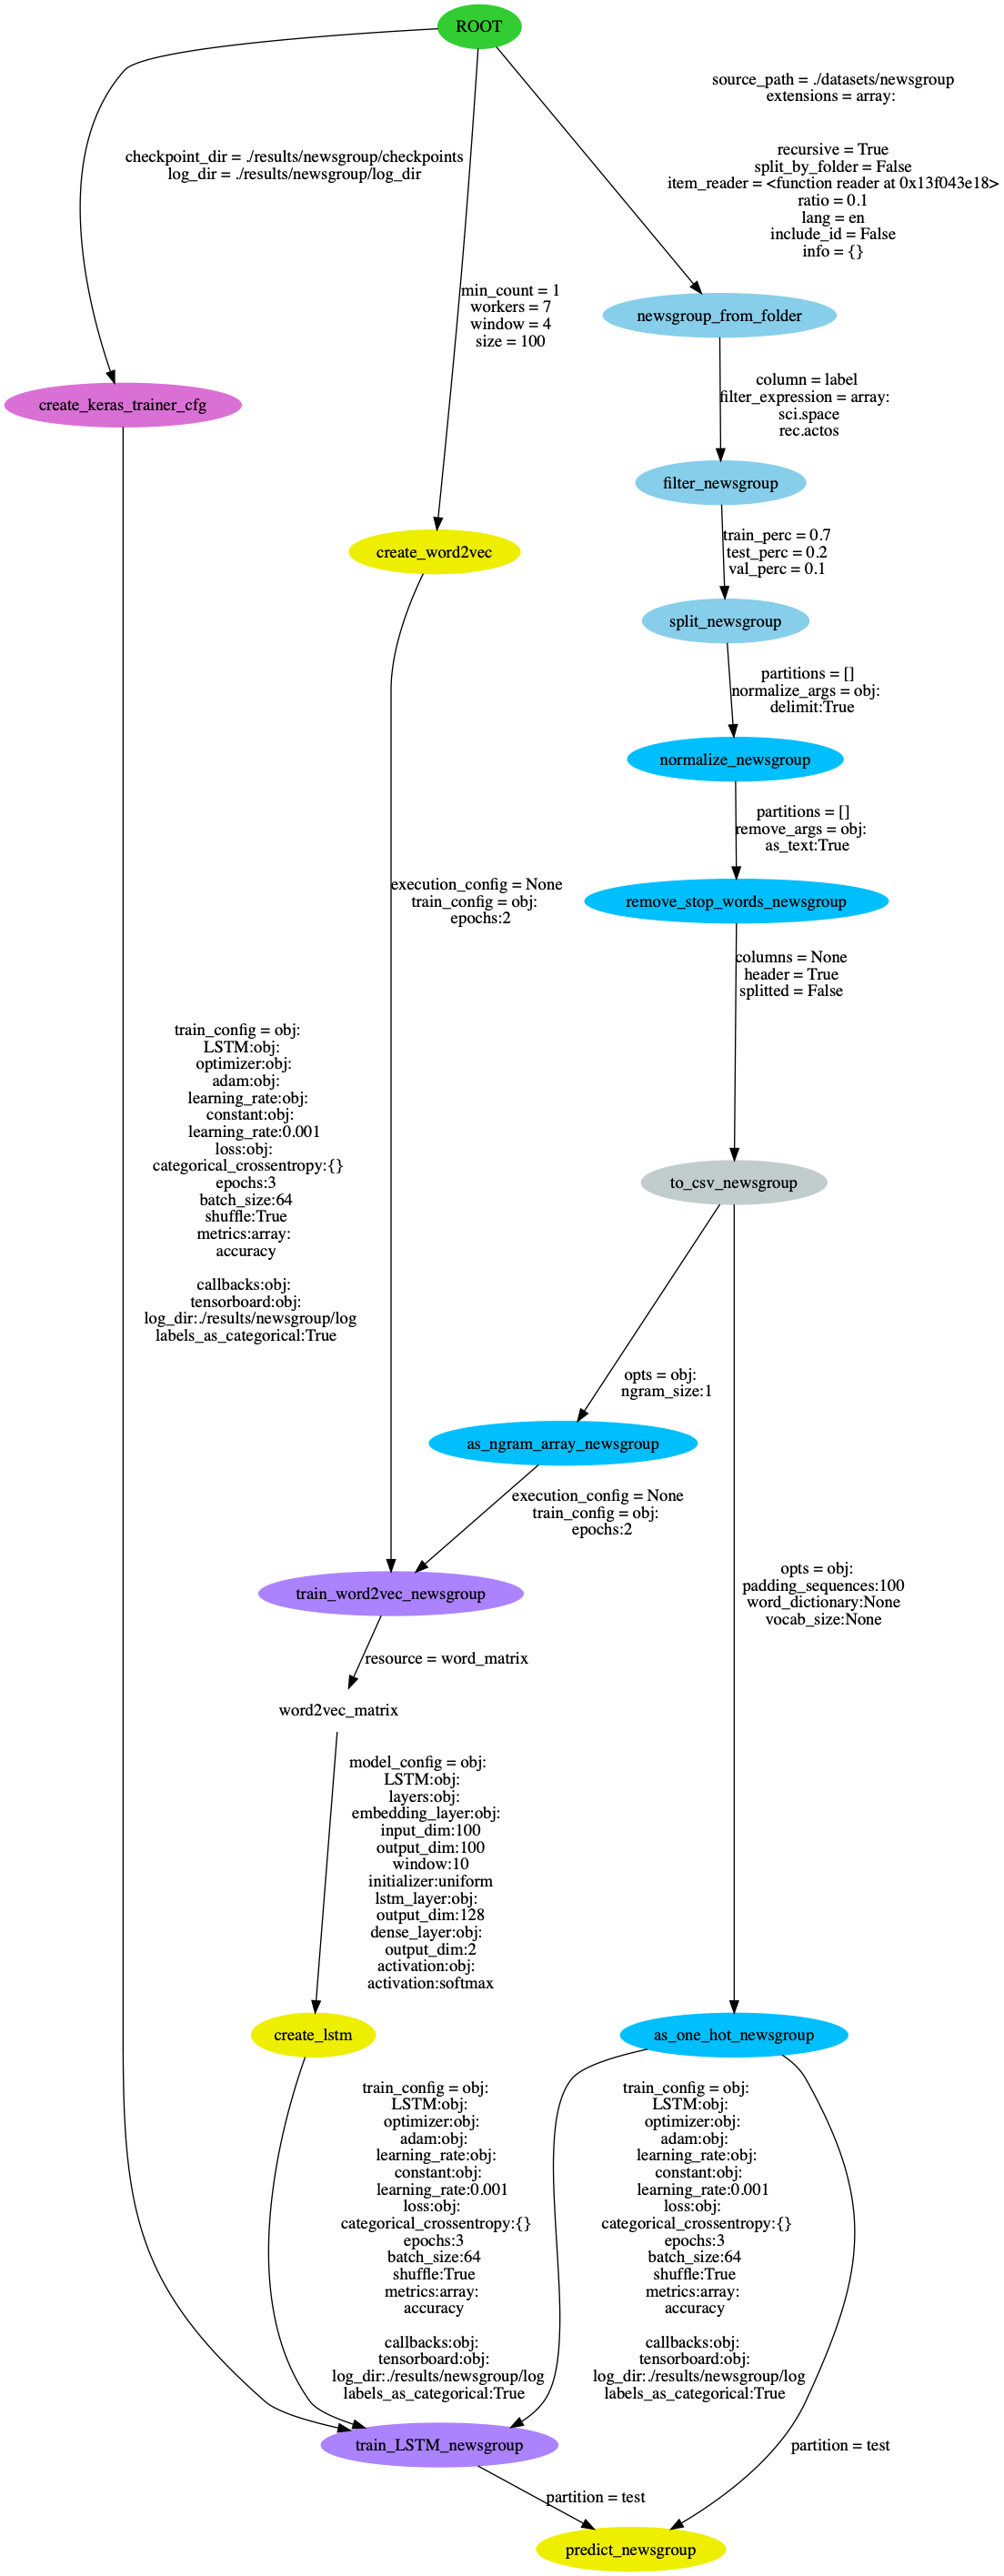

In [10]:
from IPython.display import Image
Image(os.path.join(pipeline.path, "pipeline.png"))

In [11]:
import json

with open(os.path.join(pipeline.path, "pipeline.json"), 'r') as f:
    collections = f.read()
                  
    res = json.loads(collections)

res

{'id': '20191114141559',
 'processes': [{'name': 'newsgroup_from_folder',
   'action': 'Dataset.from_folder',
   'inputs_from_processes': ['ROOT'],
   'args': {'item_reader': {'type': 'Callable',
     'file': '<ipython-input-6-556d87b60634>',
     'function': 'reader',
     'params': ['row']},
    'include_id': False,
    'info': {}}},
  {'name': 'filter_newsgroup',
   'action': 'Dataset.filter_dataset',
   'inputs_from_processes': ['newsgroup_from_folder'],
   'args': {}},
  {'name': 'split_newsgroup',
   'action': 'Dataset.split',
   'inputs_from_processes': ['filter_newsgroup'],
   'args': {}},
  {'name': 'normalize_newsgroup',
   'action': 'PreProcessing.normalize',
   'inputs_from_processes': ['split_newsgroup'],
   'args': {}},
  {'name': 'remove_stop_words_newsgroup',
   'action': 'PreProcessing.remove_stop_words',
   'inputs_from_processes': ['normalize_newsgroup'],
   'args': {'remove_args': {'as_text': True}}},
  {'name': 'to_csv_newsgroup',
   'action': 'Dataset.to_csv',
   